In [45]:
import os
import pandas as pd
import numpy as np
import sqlalchemy
import sklearn
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

connection_string = os.getenv("LINODE_CONN_STRING")
connection_string = os.getenv("LINODE_CONN_STRING")
conn = sqlalchemy.create_engine(os.getenv("LINODE_CONN_STRING")).connect()

In [47]:
data = pd.read_sql("select * from sports_data.tourney_games_through_2023_final", conn)

In [48]:
data = data.replace(np.NaN, 0)

In [49]:
data['Win_Loss_Flag'] = data['Win_Loss'].apply(lambda x: 1 if x == 'W' else 0)

In [50]:
data.columns

Index(['date', 'season', 'team', 'opponent', 'Win_Loss',
       'regular_season_win_pct', 'opponent_regular_season_win_pct',
       'season_win_pct', 'opponent_season_win_pct', 'season_ppg',
       ...
       'opponent_season_allowed_free_throw_rate_std',
       'vs_tourney_team_allowed_free_throw_rate',
       'opponent_vs_tourney_team_allowed_free_throw_rate',
       'vs_tourney_team_allowed_free_throw_rate_std',
       'opponent_vs_tourney_team_allowed_free_throw_rate_std',
       'last_10_allowed_free_throw_rate',
       'opponent_last_10_allowed_free_throw_rate',
       'last_10_allowed_free_throw_rate_std',
       'opponent_last_10_allowed_free_throw_rate_std', 'Win_Loss_Flag'],
      dtype='object', length=177)

In [51]:
predictor_cols = data.columns.to_list()

In [52]:
predictor_cols.remove('Win_Loss')
predictor_cols.remove('Win_Loss_Flag')
# 'date', 'season', 'team', 'opponent'
predictor_cols.remove('date')
predictor_cols.remove('season')
predictor_cols.remove('team')
predictor_cols.remove('opponent')

In [53]:
predictors = data[predictor_cols]
predictors_and_response = pd.concat([predictors, data['Win_Loss_Flag']], axis=1)

In [54]:
prediction_data = data[predictor_cols]
prediction_data_normalized = (prediction_data-prediction_data.mean())/prediction_data.std()

In [55]:
data['Win_Loss_Flag']

0       0
1       1
2       1
3       0
4       1
       ..
2211    0
2212    1
2213    0
2214    1
2215    0
Name: Win_Loss_Flag, Length: 2216, dtype: int64

In [56]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(prediction_data_normalized, data['Win_Loss_Flag'])

In [57]:
linreg_no_val_predictions = clf.predict(prediction_data_normalized)

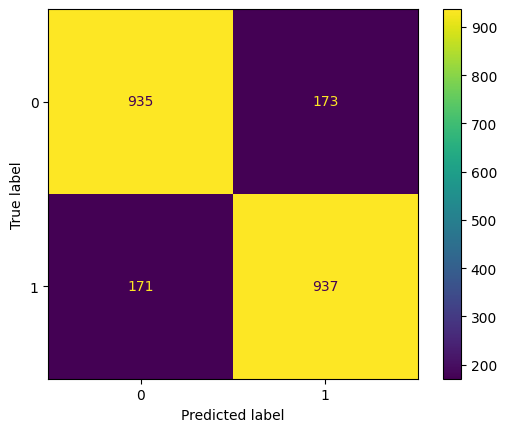

In [58]:
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(data['Win_Loss_Flag'], linreg_no_val_predictions)).plot()

In [59]:
def proper_cross_validation(clf, X, y, k=5):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=k)
    confusion_matrices = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        confusion_matrices.append(sklearn.metrics.confusion_matrix(y_test, clf.predict(X_test)))
    total_confusion_matrix = sum(confusion_matrices)
    return total_confusion_matrix

In [60]:
cms = proper_cross_validation(LogisticRegression(random_state=0), prediction_data_normalized, data['Win_Loss_Flag'])

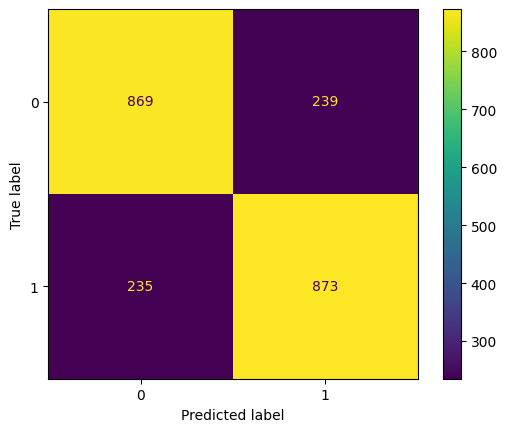

In [61]:
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

In [62]:
cms

array([[869, 239],
       [235, 873]], dtype=int64)

In [63]:
def expected_games_right(confusion_matrix):
    accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum()
    print(f"accuracy: {accuracy}")
    gr = 32.0 * accuracy
    gr = gr + (16 * (accuracy ** 2))
    gr = gr + (8 * (accuracy ** 3))
    gr = gr + (4 * (accuracy ** 4))
    gr = gr + (2 * (accuracy ** 5))
    gr = gr + (1 * (accuracy ** 6))
    return gr

In [64]:
def expected_score(confusion_matrix):
    accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum()
    gr = 32.0 * accuracy
    gr = gr + (32 * (accuracy ** 2))
    gr = gr + (32 * (accuracy ** 3))
    gr = gr + (32 * (accuracy ** 4))
    gr = gr + (32 * (accuracy ** 5))
    gr = gr + (32 * (accuracy ** 6))
    return gr

In [65]:
expected_games_right(cms)

accuracy: 0.7861010830324909


41.2925380709715

In [66]:
expected_score(cms)

89.8516395553321

accuracy: 0.7870036101083032
expected games correct: 41.3696474430498
expected score: 90.14320860460079


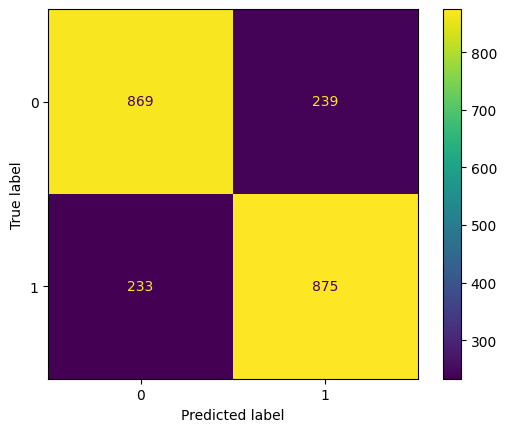

In [82]:
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
pca = PCA(n_components=171)
pca.fit(prediction_data_normalized)
# tol=0.000001, max_iter=30000, solver="liblinear"
cms = proper_cross_validation(LogisticRegression(max_iter=30000), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()
print(f"expected games correct: {expected_games_right(cms)}")
print(f"expected score: {expected_score(cms)}")

In [84]:
results_df = pd.DataFrame(columns=["n_components", "expected_games_right", "expected_score"])
for i in range(1, 172):
    pca = PCA(n_components=i)
    pca.fit(prediction_data_normalized)
    cms = proper_cross_validation(LogisticRegression(max_iter=30000), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])
    results_df = pd.concat([results_df, pd.DataFrame({"n_components": [i], "expected_games_right": [expected_games_right(cms)], "expected_score": [expected_score(cms)]})])

accuracy: 0.5049638989169675
accuracy: 0.6696750902527075
accuracy: 0.6814079422382672
accuracy: 0.7066787003610109
accuracy: 0.7084837545126353
accuracy: 0.7111913357400722
accuracy: 0.7120938628158845


C:\Users\amarl\AppData\Local\Temp\ipykernel_3144\1570475966.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({"n_components": [i], "expected_games_right": [expected_games_right(cms)], "expected_score": [expected_score(cms)]})])


accuracy: 0.7274368231046932
accuracy: 0.7324007220216606
accuracy: 0.7319494584837545
accuracy: 0.7405234657039711
accuracy: 0.7396209386281588
accuracy: 0.7355595667870036
accuracy: 0.7396209386281588
accuracy: 0.7378158844765343
accuracy: 0.7378158844765343
accuracy: 0.7414259927797834
accuracy: 0.7427797833935018
accuracy: 0.7414259927797834
accuracy: 0.7423285198555957
accuracy: 0.7351083032490975
accuracy: 0.7369133574007221
accuracy: 0.7382671480144405
accuracy: 0.7373646209386282
accuracy: 0.7360108303249098
accuracy: 0.7369133574007221
accuracy: 0.7387184115523465
accuracy: 0.7369133574007221
accuracy: 0.7319494584837545
accuracy: 0.7314981949458483
accuracy: 0.7278880866425993
accuracy: 0.7274368231046932
accuracy: 0.73014440433213
accuracy: 0.7265342960288809
accuracy: 0.7283393501805054
accuracy: 0.7274368231046932
accuracy: 0.726985559566787
accuracy: 0.7287906137184116
accuracy: 0.7324007220216606
accuracy: 0.7310469314079422
accuracy: 0.7296931407942239
accuracy: 0.72743

In [87]:
results_df.tail(30)

,n_components,expected_games_right,expected_score
0,142,40.261872,86.004380
0,143,40.908579,88.407541
0,144,41.292538,89.851640
0,145,41.331079,89.997309
0,146,41.138638,89.271259
0,147,41.138638,89.271259
0,148,40.985160,88.694537
0,149,41.023490,88.838376
0,150,41.061846,88.982442
0,151,41.061846,88.982442


In [88]:
new_data = pd.read_sql("select * from sports_data.tourney_games_2024_potential", conn)
new_data = new_data.replace(np.NaN, 0)

In [153]:
wk = new_data[new_data['team'].str.contains('Conn')]
a = wk[wk['opponent'].str.contains('Hou')].head()[['season_ppg', 'season_ppg_allowed','opponent_season_ppg', 'opponent_season_ppg_allowed']]


In [156]:
(a['season_ppg'] + a['opponent_season_ppg'] + a['season_ppg_allowed'] + a['opponent_season_ppg_allowed']) / 2

32    136.705882
dtype: float64

In [89]:
pca = PCA(n_components=171)
pca.fit(prediction_data_normalized)
# tol=0.000001, max_iter=30000, solver="liblinear"
cms = proper_cross_validation(LogisticRegression(max_iter=30000), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])
clf = LogisticRegression(random_state=0).fit(pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])

In [91]:
new_prediction_data = new_data[predictor_cols]
new_prediction_data_normalized = (new_prediction_data-prediction_data.mean())/prediction_data.std()
new_data_pca = pca.transform(new_prediction_data_normalized)

In [92]:
new_data['prediction'] = clf.predict(new_data_pca)
new_data['prediction_lose'] = [x[0] for x in clf.predict_proba(new_data_pca)]
new_data['prediction_win'] = [x[1] for x in clf.predict_proba(new_data_pca)]
preds = new_data[['season', 'team', 'opponent', 'prediction', 'prediction_lose', 'prediction_win']]

In [164]:
wk = preds[preds['team'].str.contains('Conn')]
wk[wk['opponent'].str.contains('Houston')]

,season,team,opponent,prediction,prediction_lose,prediction_win
32,2024,Connecticut,Houston,0,0.538391,0.461609
